# AM207 Paper Tutorial: 
## $\textit{Adding Gradient Noise Improves Learning for Very Deep Networks}$ 
## https://arxiv.org/pdf/1511.06807.pdf
## Chris Hase & Casey Meehan 
## $\texttt{\{christopher_hase, casey_meehan\}@g.harvard.edu}$

# I) Background Information: 

As described in the paper, noise techniques have been used to advance neural net training for over two decades. Existing methods include weight noise, adaptive weight noise, and dropout. 
- (Adaptive) Weight Noise: weights are understood to a complex posterior distribution given the data. To make the complex posterior tractable, a variational posterior is used and weights are sampled iteratively. 
 - i.e. https://www.cs.toronto.edu/~graves/nips_2011_poster.pdf
- Dropout: randomly drop entire units (and connections) from your network during training time. This produces a number of "thinned" networks, whose outputs are averaged to produce a prediction. 
 - i.e. https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
 
The benefit of NN noise techniques are two-fold: 

 - 1) Loss can converge faster by spending fewer iterations stuck at local minima 
 
 - 2) The network is inherently regularized by stochastically varying its parameters. Data overfitting is reduced. 


# II) Summary of Relevant Methods: 

In this paper, the authors' advance training noise techniques by using the declining temperature schedule of simulated annealing to both improve convergence $and$ accuracy of the network. 

The technique is theoretically simple: mean-zero normally-distributed noise is added to the network gradient at each step of an SGD optimizer. Let the network weights be represented by the vector $\mathbf{w}$, training datapoint $i$ by $\mathcal{D_i}$, and the network loss function as $f$. Then, at each step, the gradient is modified by adding normally distributed noise vector $\mathbf{B}$: 

$$
\widetilde{\nabla}_{\mathbf{w}}f(\mathcal{D_i}) = \nabla_{\mathbf{w}}f(\mathcal{D_i}) + \mathbf{B}
$$

where each element of $\mathbf{B}$ is drawn i.i.d.: 

$$
\mathbf{B}_i \sim \mathcal{N}(0, \sigma_t^2), ~\forall i 
$$

As such, the minibatch SGD optimizer with batch size $B$ updates the network weights as: 

$$
\mathbf{w}_{t+1} = \mathbf{w}_t + \sum_{i=1}^B \widetilde{\nabla}_{\mathbf{w}} f(\mathcal{D}_i)
$$

Where $t$ is the iteration number. $t$ is advanced with every backpropagation. 

One of the paper's primary contributions, is making the weight noise decline according to a temperature schedule: 

$$
\sigma^2_t = \frac{\eta}{(1+t)^\gamma}
$$

As the authors describe, this helps jump-start the training process by having high variance noise during early iterations. As noise variance declines asymptotically to 0, network accuracy can be tuned. 

In the paper, the authors experiment with $\eta = \{0.01, 0.3, 1.1\}$ and $\gamma = 0.5$. However, in this tutorial we will experiment with a wider range of values for a slightly shallower network (due to resource limiation)

Here we're importing in the necessary libraries. This tutorial will be using PyTorch for implementing the neural network with noisy gradients.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.metrics
import torch
import torchvision
from torch.autograd import Variable

At the top of this cell are helper functions for dividing the MNIST dataset into train, validation, and test sets. Following the helper functions, we divide the MNIST data into train, validation, and test sets as well as create batches for each of those data subsets. As you can see, we use batches of size 256.

In [2]:
# functions/classes taken from: https://gist.github.com/t-vi/9f6118ff84867e89f3348707c7a1271f
# to help create validation set
class PartialDataset(torch.utils.data.Dataset):
    def __init__(self, parent_ds, offset, length):
        self.parent_ds = parent_ds
        self.offset = offset
        self.length = length
        assert len(parent_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(PartialDataset, self).__init__()
    def __len__(self):
        return self.length
    def __getitem__(self, i):
        return self.parent_ds[i+self.offset]

def validation_split(dataset, val_share=0.1):
    """
       Split a (training and vaidation combined) dataset into training and validation.
       Note that to be statistically sound, the items in the dataset should be statistically
       independent (e.g. not sorted by class, not several instances of the same dataset that
       could end up in either set).
    
       inputs:
          dataset:   ("training") dataset to split into training and validation
          val_share: fraction of validation data (should be 0<val_share<1, default: 0.1)
       returns: input dataset split into test_ds, val_ds
       
       """
    val_offset = int(len(dataset)*(1-val_share))
    return PartialDataset(dataset, 0, val_offset), PartialDataset(dataset, val_offset, len(dataset)-val_offset)


torch.manual_seed(1)

# load in MNIST and create train, validation, and test sets
train_validation = torchvision.datasets.MNIST(root = os.getcwd(), train=True, transform=torchvision.transforms.ToTensor(), download = True)
train, validation = validation_split(train_validation, 1/6) # get train/validation split
test = torchvision.datasets.MNIST(root = os.getcwd(), train=False, transform=torchvision.transforms.ToTensor(), download = True)

# create batches for train, validation, and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

Here is our deep feed-forward neural network architecture. We use 12 hidden layers with ReLU activation functions. There are 10 outputs, one for each digit. Note that the reference paper uses 20 hidden layers, but we use 12 in order to save time. We also assume that a GPU is available for the user (we ran our code using GPUs on the Odyssey cluster - this is why you won't see model training, validating, and testing output in this Jupyter notebook).

In [3]:
# Deep NN architecture
# 12 layers, ReLU activations functions
class Deep_FFNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Deep_FFNN, self).__init__()
        
        self.linear1 = torch.nn.Linear(in_features = input_size, out_features = hidden_size, bias = True).cuda()
        self.relu1 = torch.nn.ReLU().cuda()
        self.linear2 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu2 = torch.nn.ReLU().cuda()
        self.linear3 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu3 = torch.nn.ReLU().cuda()
        self.linear4 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu4 = torch.nn.ReLU().cuda()
        self.linear5 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu5 = torch.nn.ReLU().cuda()
        self.linear6 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu6 = torch.nn.ReLU().cuda()
        self.linear7 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu7 = torch.nn.ReLU().cuda()
        self.linear8 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu8 = torch.nn.ReLU().cuda()
        self.linear9 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu9 = torch.nn.ReLU().cuda()
        self.linear10 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu10 = torch.nn.ReLU().cuda()
        self.linear11 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu11 = torch.nn.ReLU().cuda()
        self.linear12 = torch.nn.Linear(in_features = hidden_size, out_features = hidden_size, bias = True).cuda()
        self.relu12 = torch.nn.ReLU().cuda()
        self.linearOut = torch.nn.Linear(in_features = hidden_size, out_features = 10, bias = True).cuda()
        
    def forward(self, input):
        hidden = self.linear1(input)
        hidden = self.relu1(hidden)
        hidden = self.linear2(hidden)
        hidden = self.relu2(hidden)
        hidden = self.linear3(hidden)
        hidden = self.relu3(hidden)
        hidden = self.linear4(hidden)
        hidden = self.relu4(hidden)
        hidden = self.linear5(hidden)
        hidden = self.relu5(hidden)
        hidden = self.linear6(hidden)
        hidden = self.relu6(hidden)
        hidden = self.linear7(hidden)
        hidden = self.relu7(hidden)
        hidden = self.linear8(hidden)
        hidden = self.relu8(hidden)
        hidden = self.linear9(hidden)
        hidden = self.relu9(hidden)
        hidden = self.linear10(hidden)
        hidden = self.relu10(hidden)
        hidden = self.linear11(hidden)
        hidden = self.relu11(hidden)
        hidden = self.linear12(hidden)
        hidden = self.relu12(hidden)
        output = self.linearOut(hidden)

        return output

This cell contains a function for computing the accuracy of a model. The prediction is the digit for which the model outputs the highest probability.

In [4]:
# function for computing accuracy
def compute_accuracy(data_loader, model, input_size):
    model_pred = []
    targets = []
    
    softmax = torch.nn.Softmax() # softmax to compute output probabilities 
    for batch in data_loader:
        model_output = model(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), input_size)).cuda()) # output from NN
        model_probs = softmax(model_output).cpu().data.numpy() # digit probabilities
        model_pred += np.argmax(model_probs, axis = 1).tolist() # digit predictions
        targets += batch[1].numpy().tolist() # true digit values
        
    return sklearn.metrics.accuracy_score(targets, model_pred)

Here are the training parameters, model hyper-parameters, and the loss function. As you can see, we train for 70 epochs and minimize cross-entropy loss. We set hidden layer sizes to be 50 as in the reference paper and regularization parameter $\lambda=0.000001$. The learning rate is selected from $\{0.1, 0.01\}$, $\eta$ is selected from $\{0.00001,0.0001, 0.001, 0.01\}$, and $\gamma$ is selected from $\{0.1, 0.3,0.5,0.7,0.9\}$. Recall that we add Gaussian noise to the gradient with respect to each of the parameters for each training update. That is, $g_t \leftarrow g_t+\mathcal{N}(0,\sigma_t^2)$ where $\sigma_t^2=\dfrac{\eta}{(1+t)^\gamma}$ where $t$ is the count of the number of training steps.

In [5]:
# hyperparameters to try
lrs = [0.1, 0.01]
etas = [0.00001, 0.0001, 0.001, 0.01]
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]

input_size = 28*28 # mnist image sizes
lam = 0.000001
hidden_size = 50

num_epochs = 70
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function

Here are some plots showing the schedule of $\sigma_t^2$ over the beginning of the training period under some combinations of $\eta$ and $\gamma$. When $\gamma$ is low, $\sigma_t^2$ decreases at a lower rate. When $\eta$ is low, $\sigma_t^2$ starts at a lower value.

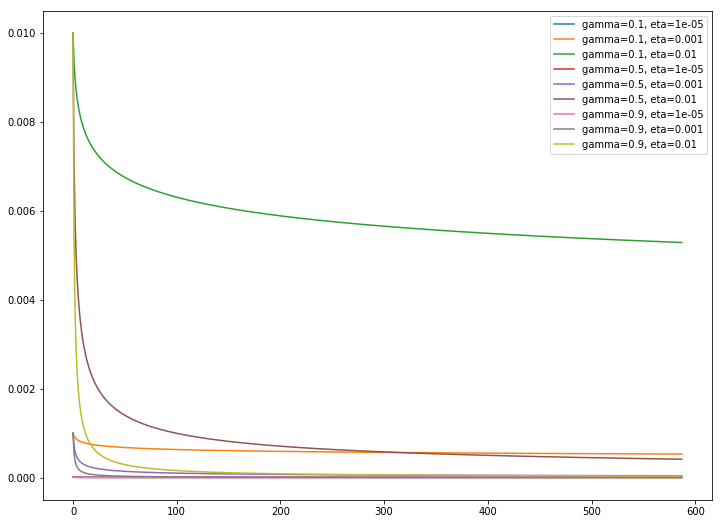

In [6]:
etas_for_plot = [0.00001, 0.001, 0.01]
gammas_for_plot = [0.1, 0.5, 0.9]
num_epochs_plot = 3

plt.figure(figsize = (12,9))
for gamma in gammas_for_plot:
    for eta in etas_for_plot:
        sigma_t2_list = []
        for t in range(len(train_loader) * num_epochs_plot):
            sigma_t2 = eta/((1 + t)**gamma) # sigma for noise
            sigma_t2_list.append(sigma_t2)
        plt.plot(np.arange(t+1), sigma_t2_list)
plt.legend(loc = 'upper right', labels = ['gamma=' + str(gamma) + ', eta=' + str(eta) for gamma in gammas_for_plot for eta in etas_for_plot])
plt.show()

Here is the code for training, validating, and testing the deep feed-forward neural network when adding gradient noise. We choose the model with the hyper-parameters that resulted in highest classification accuracy on the validation set and then compute the accuracy of the chosen model on the test set. As you can see, we add Gaussian noise to the gradient with respect to each of the parameters and update $\sigma_t^2$ at each training step. The comments should be helpful for understanding the code.

In [ ]:
### noise used in gradients
torch.manual_seed(1)

# loop through hyperparams
best_val_acc = 0
for lr in lrs:
    for gamma in gammas:
        for eta in etas:

            # instantiate model
            deep_FFNN = Deep_FFNN(input_size, hidden_size)

            # SGD optimizer
            optimizer = torch.optim.SGD(deep_FFNN.parameters(), lr, weight_decay = lam)

            # count number of training steps
            t = 0
            for epoch in range(num_epochs):   
                for batch in train_loader:
                    model_output = deep_FFNN(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), input_size)).cuda()) # model outputs
                    targets = Variable(batch[1]).cuda() # true digit values

                    optimizer.zero_grad() # zero gradient
                    loss_batch = loss_function(model_output, targets) # compute loss
                    loss_batch.backward() # take the gradient wrt parameters
                        
                    sigma_t = np.sqrt(eta/((1 + t)**gamma)) # sigma_t for noise
                    noise = torch.normal(means = torch.zeros(1), std = torch.ones(1) * sigma_t).numpy()[0].astype(np.float64) # get noise value

                    for param in list(deep_FFNN.parameters()):
                        param.grad += noise # add noise to gradient with respect to parameter
                            
                    optimizer.step() # update parameters
                    t += 1 # add to count of training steps
                                    
            # compute accuracy on validation set
            val_acc = compute_accuracy(validation_loader, deep_FFNN, input_size)
            print('Validation accuracy for gamma=' + str(gamma) + ', learning rate=' + str(lr) 
                  + ', eta=' + str(eta) + ': ' + str(val_acc))
                
            # save best model and best model hyperparams
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr
                best_gamma = gamma
                best_eta = eta
                best_model = deep_FFNN

# compute accuracy on test set
test_acc = compute_accuracy(test_loader, best_model, input_size)
print('Test accuracy for gamma=' + str(best_gamma) + ', learning rate=' + str(best_lr) 
      + ', eta=' + str(best_eta) + ': ' + str(test_acc))

Here is the code for training, validating, and testing the deep feed-forward neural network when not adding gradient noise. We choose the model whereby the corresponding learning rate resulted in the highest classification accuracy on the validation set and then computed the accuracy of the chosen model on the test set. Running this code allows us to compare methods (gradient noise vs. no gradient noise).

In [ ]:
### no noise used in gradients
torch.manual_seed(1)

# loop through hyperparams
best_val_acc = 0
for lr in lrs:
    
    # instantiate model
    deep_FFNN = Deep_FFNN(input_size, hidden_size)
    
    # SGD optimizer
    optimizer = torch.optim.SGD(deep_FFNN.parameters(), lr, weight_decay = lam)

    for epoch in range(num_epochs):   
        for batch in train_loader:
            model_output = deep_FFNN(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), input_size)).cuda()) # model predictions
            targets = Variable(batch[1]).cuda() # true digit values

            optimizer.zero_grad() # zero gradient
            loss_batch = loss_function(model_output, targets) # compute loss
            loss_batch.backward() # take the gradient wrt parameters
            optimizer.step() # update parameters
                        
                
    # compute accuracy on validation set
    val_acc = compute_accuracy(validation_loader, deep_FFNN, input_size)
    print('Validation accuracy for learning rate=' + str(lr) + ': ' + str(val_acc))
            
    # save best model and best model hyperparams
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr
        best_model = deep_FFNN

# compute accuracy on test set
test_acc = compute_accuracy(test_loader, best_model, input_size)
print('Test accuracy for learning rate=' + str(lr) + ': ' + str(test_acc))